In [40]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import pathlib
import wandb
from wandb.keras import WandbCallback
import numpy as np
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [41]:
print(tf.__version__)
print(tf.config.list_physical_devices("GPU"))

2.12.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [42]:
DATA_DIR = pathlib.Path("augmented_dataset")
AUTOTUNE = tf.data.AUTOTUNE

CONFIG = dict(
    epochs=100,
    learning_rate=1e-3,
    batch_size=16,
    img_shape=(224, 224),
    input_shape=(224, 224, 3),
    num_classes=2,
    dropout_rate=0.2,
    es_patience=20,
    valid_split=0.4,
    seed_value=42,
)

In [43]:
image_count = len(list(DATA_DIR.glob("*/*.jpg")))
healthy_count = len(list(DATA_DIR.glob("healthy/*.jpg")))
wssv_count = len(list(DATA_DIR.glob("wssv/*.jpg")))

print(f"Total number of images: {image_count}")
print(f"Healthy: {healthy_count}")
print(f"WSSV: {wssv_count}\n")

train_set, valid_set = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=CONFIG["valid_split"],
    seed=CONFIG["seed_value"],
    image_size=CONFIG["img_shape"],
    batch_size=CONFIG["batch_size"],
    label_mode="binary",
    subset="both",
)

class_names = train_set.class_names
print(f"\nClass names: {class_names}")

Total number of images: 930
Healthy: 702
WSSV: 228

Found 930 files belonging to 2 classes.
Using 558 files for training.
Using 372 files for validation.

Class names: ['healthy', 'wssv']


In [44]:
validation_batches = tf.data.experimental.cardinality(valid_set)
validation_dataset = valid_set.skip(validation_batches // 5)
test_dataset = valid_set.take(validation_batches // 5)

'''
Prefetch for faster loading
'''
train_dataset = train_set.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

'''
Get number of batches per split
'''
num_training_batches = tf.data.experimental.cardinality(train_dataset)
num_validation_batches = tf.data.experimental.cardinality(validation_dataset)
num_test_batches = tf.data.experimental.cardinality(test_dataset)

print(f"\nNumber of training batches: {num_training_batches}")
print(f"Number of validation batches: {num_validation_batches}")
print(f"Number of test batches: {num_test_batches}")


Number of training batches: 35
Number of validation batches: 20
Number of test batches: 4


In [45]:
def create_model():
    metrics = [
        tf.keras.metrics.Precision(thresholds=0, name='precision'),
        tf.keras.metrics.Recall(thresholds=0, name='recall'),
        tfa.metrics.F1Score(num_classes=1, average="weighted", name="f1_score", threshold=0.5),
        tf.keras.metrics.FalseNegatives(thresholds=0, name='false_negatives'),
        tf.keras.metrics.TruePositives(thresholds=0, name='true_positives')
    ]
    
    base_model = tf.keras.applications.MobileNetV3Small(input_shape=CONFIG["input_shape"], include_top=False)
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=CONFIG["input_shape"])
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(rate=CONFIG["dropout_rate"], seed=CONFIG["seed_value"])(x)
    outputs = tf.keras.layers.Dense(units=1)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG["learning_rate"]),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=metrics,
    )

    return model

In [46]:
class_0_weight = (1 / healthy_count) * (image_count / 2.0)
class_1_weight = (1 / wssv_count) * (image_count / 2.0)
class_weight = {0: class_0_weight, 1: class_1_weight}

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=CONFIG["es_patience"]),
    tf.keras.callbacks.ModelCheckpoint(
        filepath="checkpoints/cp-{epoch:04d}.ckpt",
        save_weights_only=True,
        monitor="val_loss",
        mode="min",
        verbose=1,
        save_best_only=True,
    ),
    tfa.callbacks.TQDMProgressBar()
]

model = create_model()

history = model.fit(
    train_dataset,
    epochs=CONFIG["epochs"],
    validation_data=validation_dataset,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=0
)

Training:   0%|                                                                                               …

Epoch 1/100


2023-05-17 00:19:04.470110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [558]
	 [[{{node Placeholder/_0}}]]
2023-05-17 00:19:04.470462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_21' with dtype float and shape [2]
	 [[{{node Placeholder/_21}}]]


0/35                                                                                                          …

2023-05-17 00:19:07.639913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [372]
	 [[{{node Placeholder/_4}}]]
2023-05-17 00:19:07.640158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [372]
	 [[{{node Placeholder/_4}}]]



Epoch 1: val_loss improved from inf to 0.59382, saving model to checkpoints/cp-0001.ckpt
Epoch 2/100


0/35                                                                                                          …


Epoch 2: val_loss improved from 0.59382 to 0.45638, saving model to checkpoints/cp-0002.ckpt
Epoch 3/100


0/35                                                                                                          …


Epoch 3: val_loss improved from 0.45638 to 0.41495, saving model to checkpoints/cp-0003.ckpt
Epoch 4/100


0/35                                                                                                          …


Epoch 4: val_loss improved from 0.41495 to 0.39756, saving model to checkpoints/cp-0004.ckpt
Epoch 5/100


0/35                                                                                                          …


Epoch 5: val_loss improved from 0.39756 to 0.34727, saving model to checkpoints/cp-0005.ckpt
Epoch 6/100


0/35                                                                                                          …


Epoch 6: val_loss did not improve from 0.34727
Epoch 7/100


0/35                                                                                                          …


Epoch 7: val_loss improved from 0.34727 to 0.31746, saving model to checkpoints/cp-0007.ckpt
Epoch 8/100


0/35                                                                                                          …


Epoch 8: val_loss did not improve from 0.31746
Epoch 9/100


0/35                                                                                                          …


Epoch 9: val_loss improved from 0.31746 to 0.30836, saving model to checkpoints/cp-0009.ckpt
Epoch 10/100


0/35                                                                                                          …


Epoch 10: val_loss improved from 0.30836 to 0.27832, saving model to checkpoints/cp-0010.ckpt
Epoch 11/100


0/35                                                                                                          …


Epoch 11: val_loss did not improve from 0.27832
Epoch 12/100


0/35                                                                                                          …


Epoch 12: val_loss improved from 0.27832 to 0.27019, saving model to checkpoints/cp-0012.ckpt
Epoch 13/100


0/35                                                                                                          …


Epoch 13: val_loss did not improve from 0.27019
Epoch 14/100


0/35                                                                                                          …


Epoch 14: val_loss improved from 0.27019 to 0.25011, saving model to checkpoints/cp-0014.ckpt
Epoch 15/100


0/35                                                                                                          …


Epoch 15: val_loss improved from 0.25011 to 0.23929, saving model to checkpoints/cp-0015.ckpt
Epoch 16/100


0/35                                                                                                          …


Epoch 16: val_loss did not improve from 0.23929
Epoch 17/100


0/35                                                                                                          …


Epoch 17: val_loss improved from 0.23929 to 0.23425, saving model to checkpoints/cp-0017.ckpt
Epoch 18/100


0/35                                                                                                          …


Epoch 18: val_loss improved from 0.23425 to 0.22629, saving model to checkpoints/cp-0018.ckpt
Epoch 19/100


0/35                                                                                                          …


Epoch 19: val_loss improved from 0.22629 to 0.21873, saving model to checkpoints/cp-0019.ckpt
Epoch 20/100


0/35                                                                                                          …


Epoch 20: val_loss improved from 0.21873 to 0.21572, saving model to checkpoints/cp-0020.ckpt
Epoch 21/100


0/35                                                                                                          …


Epoch 21: val_loss improved from 0.21572 to 0.21427, saving model to checkpoints/cp-0021.ckpt
Epoch 22/100


0/35                                                                                                          …


Epoch 22: val_loss improved from 0.21427 to 0.21164, saving model to checkpoints/cp-0022.ckpt
Epoch 23/100


0/35                                                                                                          …


Epoch 23: val_loss improved from 0.21164 to 0.20589, saving model to checkpoints/cp-0023.ckpt
Epoch 24/100


0/35                                                                                                          …


Epoch 24: val_loss did not improve from 0.20589
Epoch 25/100


0/35                                                                                                          …


Epoch 25: val_loss improved from 0.20589 to 0.19662, saving model to checkpoints/cp-0025.ckpt
Epoch 26/100


0/35                                                                                                          …


Epoch 26: val_loss did not improve from 0.19662
Epoch 27/100


0/35                                                                                                          …


Epoch 27: val_loss improved from 0.19662 to 0.19206, saving model to checkpoints/cp-0027.ckpt
Epoch 28/100


0/35                                                                                                          …


Epoch 28: val_loss improved from 0.19206 to 0.18708, saving model to checkpoints/cp-0028.ckpt
Epoch 29/100


0/35                                                                                                          …


Epoch 29: val_loss improved from 0.18708 to 0.18421, saving model to checkpoints/cp-0029.ckpt
Epoch 30/100


0/35                                                                                                          …


Epoch 30: val_loss did not improve from 0.18421
Epoch 31/100


0/35                                                                                                          …


Epoch 31: val_loss did not improve from 0.18421
Epoch 32/100


0/35                                                                                                          …


Epoch 32: val_loss improved from 0.18421 to 0.17928, saving model to checkpoints/cp-0032.ckpt
Epoch 33/100


0/35                                                                                                          …


Epoch 33: val_loss improved from 0.17928 to 0.17301, saving model to checkpoints/cp-0033.ckpt
Epoch 34/100


0/35                                                                                                          …


Epoch 34: val_loss improved from 0.17301 to 0.17103, saving model to checkpoints/cp-0034.ckpt
Epoch 35/100


0/35                                                                                                          …


Epoch 35: val_loss did not improve from 0.17103
Epoch 36/100


0/35                                                                                                          …


Epoch 36: val_loss improved from 0.17103 to 0.16334, saving model to checkpoints/cp-0036.ckpt
Epoch 37/100


0/35                                                                                                          …


Epoch 37: val_loss did not improve from 0.16334
Epoch 38/100


0/35                                                                                                          …


Epoch 38: val_loss did not improve from 0.16334
Epoch 39/100


0/35                                                                                                          …


Epoch 39: val_loss improved from 0.16334 to 0.15957, saving model to checkpoints/cp-0039.ckpt
Epoch 40/100


0/35                                                                                                          …


Epoch 40: val_loss improved from 0.15957 to 0.15275, saving model to checkpoints/cp-0040.ckpt
Epoch 41/100


0/35                                                                                                          …


Epoch 41: val_loss did not improve from 0.15275
Epoch 42/100


0/35                                                                                                          …


Epoch 42: val_loss improved from 0.15275 to 0.15161, saving model to checkpoints/cp-0042.ckpt
Epoch 43/100


0/35                                                                                                          …


Epoch 43: val_loss improved from 0.15161 to 0.14971, saving model to checkpoints/cp-0043.ckpt
Epoch 44/100


0/35                                                                                                          …


Epoch 44: val_loss improved from 0.14971 to 0.14447, saving model to checkpoints/cp-0044.ckpt
Epoch 45/100


0/35                                                                                                          …


Epoch 45: val_loss did not improve from 0.14447
Epoch 46/100


0/35                                                                                                          …


Epoch 46: val_loss did not improve from 0.14447
Epoch 47/100


0/35                                                                                                          …


Epoch 47: val_loss improved from 0.14447 to 0.14067, saving model to checkpoints/cp-0047.ckpt
Epoch 48/100


0/35                                                                                                          …


Epoch 48: val_loss did not improve from 0.14067
Epoch 49/100


0/35                                                                                                          …


Epoch 49: val_loss did not improve from 0.14067
Epoch 50/100


0/35                                                                                                          …


Epoch 50: val_loss improved from 0.14067 to 0.13656, saving model to checkpoints/cp-0050.ckpt
Epoch 51/100


0/35                                                                                                          …


Epoch 51: val_loss improved from 0.13656 to 0.13594, saving model to checkpoints/cp-0051.ckpt
Epoch 52/100


0/35                                                                                                          …


Epoch 52: val_loss improved from 0.13594 to 0.13495, saving model to checkpoints/cp-0052.ckpt
Epoch 53/100


0/35                                                                                                          …


Epoch 53: val_loss improved from 0.13495 to 0.13450, saving model to checkpoints/cp-0053.ckpt
Epoch 54/100


0/35                                                                                                          …


Epoch 54: val_loss improved from 0.13450 to 0.13049, saving model to checkpoints/cp-0054.ckpt
Epoch 55/100


0/35                                                                                                          …


Epoch 55: val_loss did not improve from 0.13049
Epoch 56/100


0/35                                                                                                          …


Epoch 56: val_loss improved from 0.13049 to 0.12726, saving model to checkpoints/cp-0056.ckpt
Epoch 57/100


0/35                                                                                                          …


Epoch 57: val_loss did not improve from 0.12726
Epoch 58/100


0/35                                                                                                          …


Epoch 58: val_loss did not improve from 0.12726
Epoch 59/100


0/35                                                                                                          …


Epoch 59: val_loss improved from 0.12726 to 0.12457, saving model to checkpoints/cp-0059.ckpt
Epoch 60/100


0/35                                                                                                          …


Epoch 60: val_loss did not improve from 0.12457
Epoch 61/100


0/35                                                                                                          …


Epoch 61: val_loss improved from 0.12457 to 0.12397, saving model to checkpoints/cp-0061.ckpt
Epoch 62/100


0/35                                                                                                          …


Epoch 62: val_loss improved from 0.12397 to 0.12283, saving model to checkpoints/cp-0062.ckpt
Epoch 63/100


0/35                                                                                                          …


Epoch 63: val_loss did not improve from 0.12283
Epoch 64/100


0/35                                                                                                          …


Epoch 64: val_loss did not improve from 0.12283
Epoch 65/100


0/35                                                                                                          …


Epoch 65: val_loss improved from 0.12283 to 0.11804, saving model to checkpoints/cp-0065.ckpt
Epoch 66/100


0/35                                                                                                          …


Epoch 66: val_loss did not improve from 0.11804
Epoch 67/100


0/35                                                                                                          …


Epoch 67: val_loss did not improve from 0.11804
Epoch 68/100


0/35                                                                                                          …


Epoch 68: val_loss improved from 0.11804 to 0.11700, saving model to checkpoints/cp-0068.ckpt
Epoch 69/100


0/35                                                                                                          …


Epoch 69: val_loss did not improve from 0.11700
Epoch 70/100


0/35                                                                                                          …


Epoch 70: val_loss did not improve from 0.11700
Epoch 71/100


0/35                                                                                                          …


Epoch 71: val_loss improved from 0.11700 to 0.11345, saving model to checkpoints/cp-0071.ckpt
Epoch 72/100


0/35                                                                                                          …


Epoch 72: val_loss improved from 0.11345 to 0.11232, saving model to checkpoints/cp-0072.ckpt
Epoch 73/100


0/35                                                                                                          …


Epoch 73: val_loss improved from 0.11232 to 0.11103, saving model to checkpoints/cp-0073.ckpt
Epoch 74/100


0/35                                                                                                          …


Epoch 74: val_loss did not improve from 0.11103
Epoch 75/100


0/35                                                                                                          …


Epoch 75: val_loss did not improve from 0.11103
Epoch 76/100


0/35                                                                                                          …


Epoch 76: val_loss improved from 0.11103 to 0.10798, saving model to checkpoints/cp-0076.ckpt
Epoch 77/100


0/35                                                                                                          …


Epoch 77: val_loss improved from 0.10798 to 0.10501, saving model to checkpoints/cp-0077.ckpt
Epoch 78/100


0/35                                                                                                          …


Epoch 78: val_loss did not improve from 0.10501
Epoch 79/100


0/35                                                                                                          …


Epoch 79: val_loss did not improve from 0.10501
Epoch 80/100


0/35                                                                                                          …


Epoch 80: val_loss did not improve from 0.10501
Epoch 81/100


0/35                                                                                                          …


Epoch 81: val_loss did not improve from 0.10501
Epoch 82/100


0/35                                                                                                          …


Epoch 82: val_loss improved from 0.10501 to 0.10440, saving model to checkpoints/cp-0082.ckpt
Epoch 83/100


0/35                                                                                                          …


Epoch 83: val_loss did not improve from 0.10440
Epoch 84/100


0/35                                                                                                          …


Epoch 84: val_loss improved from 0.10440 to 0.10408, saving model to checkpoints/cp-0084.ckpt
Epoch 85/100


0/35                                                                                                          …


Epoch 85: val_loss improved from 0.10408 to 0.10255, saving model to checkpoints/cp-0085.ckpt
Epoch 86/100


0/35                                                                                                          …


Epoch 86: val_loss did not improve from 0.10255
Epoch 87/100


0/35                                                                                                          …


Epoch 87: val_loss improved from 0.10255 to 0.10060, saving model to checkpoints/cp-0087.ckpt
Epoch 88/100


0/35                                                                                                          …


Epoch 88: val_loss improved from 0.10060 to 0.09868, saving model to checkpoints/cp-0088.ckpt
Epoch 89/100


0/35                                                                                                          …


Epoch 89: val_loss did not improve from 0.09868
Epoch 90/100


0/35                                                                                                          …


Epoch 90: val_loss improved from 0.09868 to 0.09850, saving model to checkpoints/cp-0090.ckpt
Epoch 91/100


0/35                                                                                                          …


Epoch 91: val_loss improved from 0.09850 to 0.09699, saving model to checkpoints/cp-0091.ckpt
Epoch 92/100


0/35                                                                                                          …


Epoch 92: val_loss did not improve from 0.09699
Epoch 93/100


0/35                                                                                                          …


Epoch 93: val_loss improved from 0.09699 to 0.09610, saving model to checkpoints/cp-0093.ckpt
Epoch 94/100


0/35                                                                                                          …


Epoch 94: val_loss did not improve from 0.09610
Epoch 95/100


0/35                                                                                                          …


Epoch 95: val_loss did not improve from 0.09610
Epoch 96/100


0/35                                                                                                          …


Epoch 96: val_loss improved from 0.09610 to 0.09458, saving model to checkpoints/cp-0096.ckpt
Epoch 97/100


0/35                                                                                                          …


Epoch 97: val_loss improved from 0.09458 to 0.09351, saving model to checkpoints/cp-0097.ckpt
Epoch 98/100


0/35                                                                                                          …


Epoch 98: val_loss did not improve from 0.09351
Epoch 99/100


0/35                                                                                                          …


Epoch 99: val_loss did not improve from 0.09351
Epoch 100/100


0/35                                                                                                          …


Epoch 100: val_loss did not improve from 0.09351


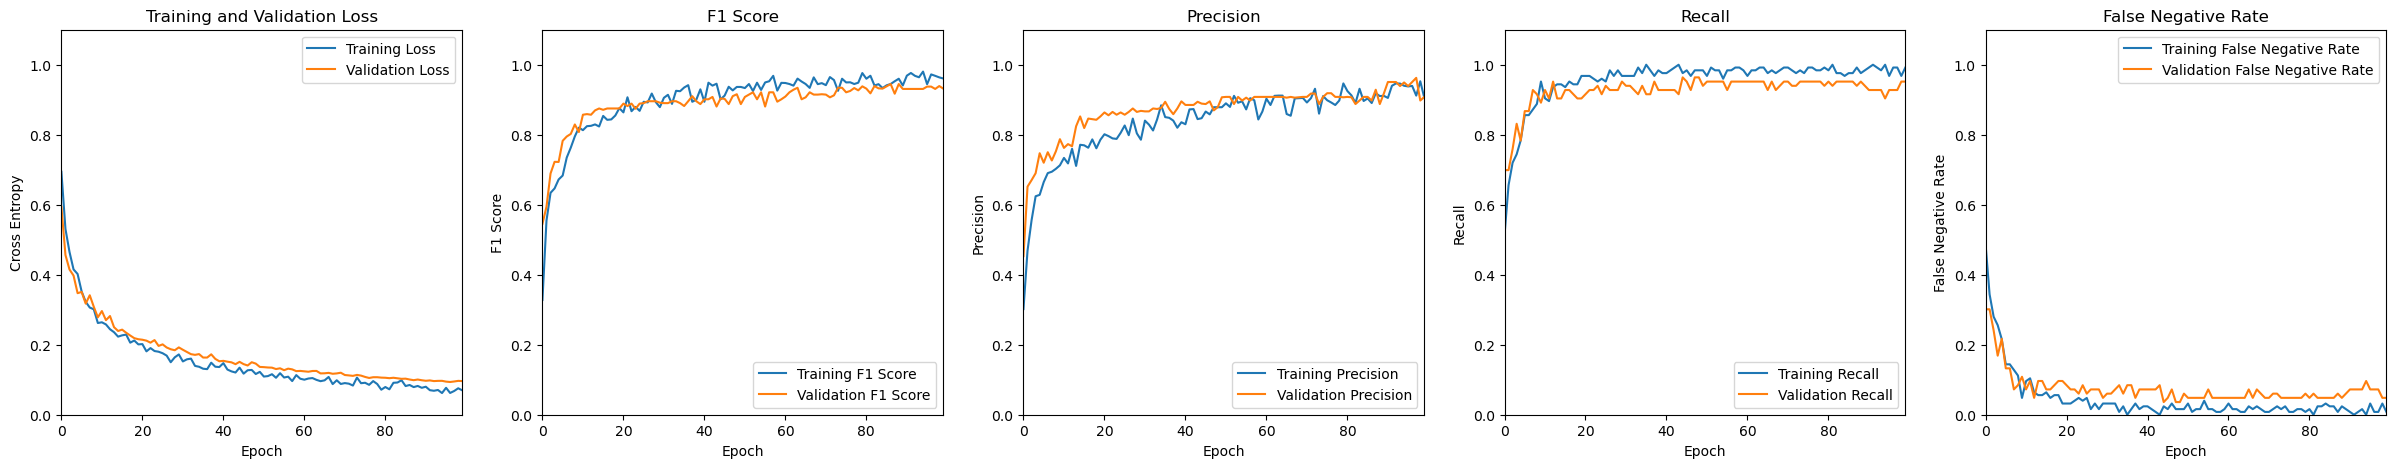

In [47]:
plt.figure(figsize=(30, 5), dpi=100)

plt.subplot(1, 5, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.ylim([0, 1.1])
plt.xlim([0, history.epoch[-1]])
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")

plt.subplot(1, 5, 2)
plt.plot(history.history["f1_score"], label="Training F1 Score")
plt.plot(history.history["val_f1_score"], label="Validation F1 Score")
plt.legend(loc="lower right")
plt.ylabel("F1 Score")
plt.ylim([0, 1.1])
plt.xlim([0, history.epoch[-1]])
plt.title("F1 Score")
plt.xlabel("Epoch")

plt.subplot(1, 5, 3)
plt.plot(history.history["precision"], label="Training Precision")
plt.plot(history.history["val_precision"], label="Validation Precision")
plt.legend(loc="lower right")
plt.ylabel("Precision")
plt.ylim([0, 1.1])
plt.xlim([0, history.epoch[-1]])
plt.xlabel("Epoch")
plt.title("Precision")

plt.subplot(1, 5, 4)
plt.plot(history.history["recall"], label="Training Recall")
plt.plot(history.history["val_recall"], label="Validation Recall")
plt.legend(loc="lower right")
plt.ylabel("Recall")
plt.ylim([0, 1.1])
plt.xlim([0, history.epoch[-1]])
plt.title("Recall")
plt.xlabel("Epoch")

false_neg = history.history["false_negatives"]
val_false_neg = history.history["val_false_negatives"]

fnr = np.array(history.history["false_negatives"]) / (np.array(history.history["false_negatives"]) + np.array(history.history["true_positives"]))
val_fnr = np.array(history.history["val_false_negatives"]) / (np.array(history.history["val_false_negatives"]) + np.array(history.history["val_true_positives"]))
plt.subplot(1, 5, 5)
plt.plot(fnr, label="Training False Negative Rate")
plt.plot(val_fnr, label="Validation False Negative Rate")
plt.legend(loc="upper right")
plt.ylabel("False Negative Rate")
plt.ylim([0, 1.1])
plt.xlim([0, history.epoch[-1]])
plt.title("False Negative Rate")
plt.xlabel("Epoch")

plt.show()

In [48]:
base_path = "checkpoints_training/cp-0001.ckpt"

checkpoint_dir = os.path.dirname(checkpoint_path)
best_weights = tf.train.latest_checkpoint(checkpoint_dir)

print("Naive Model")
model.load_weights(base_path)
results = np.round(model.evaluate(test_dataset, verbose=0), 4)
print(f"Loss: {results[0]}")
print(f"Precision: {results[1]}")
print(f"Recall: {results[2]}")
print(f"F1-Score: {results[3]}")
print(f"False Negative Rate: {results[4] / (results[4] + results[5])}")

print("\nBest Model")
model.load_weights(best_weights)
results = np.round(model.evaluate(test_dataset, verbose=0), 4)
print(f"Loss: {results[0]}")
print(f"Precision: {results[1]}")
print(f"Recall: {results[2]}")
print(f"F1-Score: {results[3]}")
print(f"False Negative Rate: {results[4] / (results[4] + results[5])}")

Naive Model


2023-05-17 00:22:03.790395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [372]
	 [[{{node Placeholder/_4}}]]
2023-05-17 00:22:03.790653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [372]
	 [[{{node Placeholder/_4}}]]


Loss: 0.4751
Precision: 0.6154
Recall: 0.8
F1-Score: 0.6667
False Negative Rate: 0.2

Best Model
Loss: 0.0882
Precision: 0.8636
Recall: 0.95
F1-Score: 0.95
False Negative Rate: 0.05
